## load the data

In [ ]:
import urllib.request as req
from urllib.parse import urlparse
import os
import progressbar
import zipfile
import gzip
import shutil
import json
import pandas as pd
import re
import string

pbar = None


def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

def wget(url):
    a = urlparse(url)
    filename = os.path.basename(a.path)
    if not os.path.isfile(filename):
        req.urlretrieve(url, filename, show_progress)
        print(f'downloaded to {filename}')
    else:
        print(f'file {filename} has already been downloaded')
    return filename

Video_Games_5 = wget('http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz')
df = pd.read_json("./Video_Games_5.json.gz", lines=True, compression='gzip')


# some simple preprocessing
df = df[df['reviewText'].notnull()]
df['reviewText'] = df['reviewText'].str.lower()
df['reviewText'] = df['reviewText'].str.replace('[{}]'.format(string.punctuation), '')
df['reviewText'] = df['reviewText'].str.replace('\n', ' ')

100% (154050105 of 154050105) |##########| Elapsed Time: 0:00:07 Time:  0:00:07


downloaded to Video_Games_5.json.gz


In [ ]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,this game is a bit hard to get the hang of but...,but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,i played it a while but it was alright the ste...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,found the game a bit too complicated not what ...,Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,great game i love it and have played it since ...,love this game,1419465600,NaN,NaN,NaN


In [ ]:
from datetime import datetime

def year_month(unixReviewTime):
    time = datetime.utcfromtimestamp(unixReviewTime)
    return f'{time.year}{time.month:02d}'

df['year_month'] = df.unixReviewTime.apply(year_month)
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,year_month
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,this game is a bit hard to get the hang of but...,but when you do it's great.,1445040000,NaN,NaN,NaN,201510
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,i played it a while but it was alright the ste...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN,201507
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game,Three Stars,1424649600,NaN,NaN,NaN,201502
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,found the game a bit too complicated not what ...,Two Stars,1424390400,NaN,NaN,NaN,201502
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,great game i love it and have played it since ...,love this game,1419465600,NaN,NaN,NaN,201412


In [ ]:
df.year_month.value_counts().sort_values(ascending=False).head()

201412    10104
201501     9910
201502     9490
201503     8919
201601     8690
Name: year_month, dtype: int64

In [ ]:
df[df.year_month=='201501'].overall.value_counts().sort_values()

2     328
1     431
3     769
4    1456
5    6926
Name: overall, dtype: int64

In [ ]:
df[df.year_month=='201502'].overall.value_counts().sort_values()

2     305
1     422
3     701
4    1406
5    6656
Name: overall, dtype: int64

In [ ]:
old_df = df[df.year_month=='201501']
new_df = df[df.year_month=='201502']

## drift understanding using visualisation

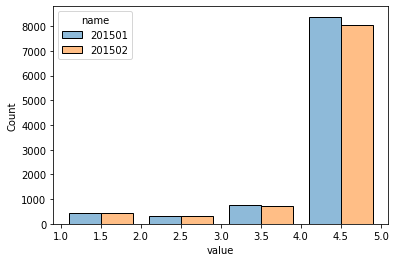

In [ ]:
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

vis_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': list(old_df.overall), 'name': '201501'}),
    pd.DataFrame.from_dict({'value': list(new_df.overall), 'name': '201502'})
])
fig, ax = plt.subplots()
sns.histplot(
    data=vis_df, x='value', hue='name', multiple='dodge', alpha=0.5, shrink=.8,
    bins=[1,2,3,4,5], ax=ax
)

## difference using kl divergence and earth movers distance

current difference

In [ ]:
from scipy.stats import wasserstein_distance, entropy

x = old_df.overall.value_counts().sort_index()
y = new_df.overall.value_counts().sort_index()

print('wasserstein_distance:', wasserstein_distance(x, y))
print('kl divergence:', entropy(x, y))

wasserstein_distance: 83.99999999999999
kl divergence: 0.00012718655172293302


if they are exactly the same

In [ ]:
print('wasserstein_distance:', wasserstein_distance(x, x))
print('kl divergence:', entropy(x, x))

wasserstein_distance: 0.0
kl divergence: 0.0


In [ ]:
y

1     422
2     305
3     701
4    1406
5    6656
Name: overall, dtype: int64

if around 500 people suddenly got discgrunted due to some issue

In [ ]:
y_ = y
print('original y', y_)
y_.loc[1] += 1000
y_.loc[5] -= 1000
print('changed y', y_)

print('wasserstein_distance:', wasserstein_distance(x, y_))
print('kl divergence:', entropy(x, y_))

original y 1     422
2     305
3     701
4    1406
5    6656
Name: overall, dtype: int64
changed y 1    1422
2     305
3     701
4    1406
5    5656
Name: overall, dtype: int64
wasserstein_distance: 83.99999999999999
kl divergence: 0.00021535619497555425


In [ ]:
y_ = y
print('original y', y_)
y_ = [int(.7 * item) for item in y_]
print('changed y', y_)

print('wasserstein_distance:', wasserstein_distance(x, y_))
print('kl divergence:', entropy(x, y_))

original y 1    1422
2     305
3     701
4    1406
5    5656
Name: overall, dtype: int64
changed y [995, 213, 490, 984, 3959]
wasserstein_distance: 653.8
kl divergence: 0.00022072692190882215


In [ ]:
print(0.00022072692190882215/0.00012718655172293302, 653.8/83.99999999999999)

(1.7354580253866798, 7.783333333333334)

## discriminative classifier

going ahead with fasttext but you can go ahead with any model of your choice.

fasttext has good out of vocabulary support and there are a lot of spelling mistakes in the data

In [ ]:
%%bash
wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
unzip v0.9.2.zip
cd fastText-0.9.2
make
pip install .

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
  inflating: fastText-0.9.2/.circleci/cmake_test.sh  
  inflating: fastText-0.9.2/.circleci/config.yml  
  inflating: fastText-0.9.2/.circleci/gcc_test.sh  
  inflating: fastText-0.9.2/.circleci/pip_test.sh  
  inflating: fastText-0.9.2/.circleci/pull_data.sh  
  inflating: fastText-0.9.2/.circleci/python_test.sh  
  inflating: fastText-0.9.2/.circleci/run_locally.sh  
  inflating: fastText-0.9.2/.circleci/setup_circleimg.sh  
  inflating: fastText-0.9.2/.circleci/setup_debian.sh  
  inflating: fastText-0.9.2/.gitignore  
  inflating: fastText-0.9.2/CMakeLists.txt  
  inflating: fastText-0.9.2/CODE_OF_CONDUCT.md  
  inflating: fastText-0.9.2/CONTRIBUTING.md  
  inflating: fastText-0.9.2/LICENSE  
  inflating: fastText-0.9.2/MANIFEST.in  
  inflating: fastText-0.9.2/Makefile  
  inflating: fastText-0.9.2/README.md  
   creating: fastText-0.9.2/alignment/
  in

--2021-12-13 02:14:39--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2 [following]
--2021-12-13 02:14:40--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 13.112.159.149
Connecting to codeload.github.com (codeload.github.com)|13.112.159.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

     0K .......... .......... .......... .......... ..........  688K
    50K .......... .......... .......... .......... .......... 1.35M
   100K .......... .......... .......... .......... .......... 34.7M
   150K .......... .......... .......... .......... .......... 1.42M
   200K ..........

In [ ]:
!cd fastText-0.9.2 && ./fasttext

usage: fasttext <command> <args>

The commands supported by fasttext are:

  supervised              train a supervised classifier
  quantize                quantize a model to reduce the memory usage
  test                    evaluate a supervised classifier
  test-label              print labels with precision and recall scores
  predict                 predict most likely labels
  predict-prob            predict most likely labels with probabilities
  skipgram                train a skipgram model
  cbow                    train a cbow model
  print-word-vectors      print word vectors given a trained model
  print-sentence-vectors  print sentence vectors given a trained model
  print-ngrams            print ngrams given a trained model and word
  nn                      query for nearest neighbors
  analogies               query for analogies
  dump                    dump arguments,dictionary,input/output vectors



In [ ]:
old_df['new_data'] = '__label__old'
new_df['new_data'] = '__label__new'

total_df = pd.concat([old_df, new_df])
total_df['ft_data'] = total_df.new_data + ' ' + total_df.reviewText

total_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,year_month,new_data,ft_data
21,4,True,"01 31, 2015",A2RGUDIF7VB7JZ,0700026398,Johnathan Scott,good game,Four Stars,1422662400,NaN,NaN,NaN,201501,__label__old,__label__old good game
62,4,True,"01 13, 2015",A2JBQEETZQ56YP,0804161380,Patrick Christensen,a great collectors item i dont want to get rid...,Four Stars,1421107200,NaN,{'Format:': ' Hardcover'},NaN,201501,__label__old,__label__old a great collectors item i dont wa...
63,5,True,"01 2, 2015",A28NUXQ2ONMT89,0804161380,trojanboy_cdx,best idea to put all these books in a collecto...,Five Stars,1420156800,NaN,{'Format:': ' Hardcover'},NaN,201501,__label__old,__label__old best idea to put all these books ...
239,4,True,"01 25, 2015",A2UKS3ZLKMXAZD,9629971372,XaviersFinest,this thing is really great for those with a bi...,This thing is really great for those with a bi...,1422144000,NaN,NaN,NaN,201501,__label__old,__label__old this thing is really great for th...
240,1,True,"01 14, 2015",A2KGTIG05HRSAV,9629971372,Coasty,i was really mad that on the buying site it sa...,I was really mad that on the buying site it ...,1421193600,NaN,NaN,NaN,201501,__label__old,__label__old i was really mad that on the buyi...


### train test split

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(total_df, test_size=0.3, random_state=42)

train_df['ft_data'].to_csv('train.txt', index=False, header=False)
test_df['ft_data'].to_csv('test.txt', index=False, header=False)

In [ ]:
!head train.txt

__label__old it works great
__label__old way better than i thought it would be
__label__new decent game just thought single player was a little lacking in missions and rather short for money paid multiplayer riddled with hackers and snipers just like most on line games got way more bang for my buck with far cry 4
__label__old there are few games that eschew the copy and paste formula that mario kart has set for itself  since its inception in the early 90s on the super nintendo mario kart has pretty much been the same game time and time again  sure theyve sometimes added twists such as with double dash or tried to do things like custom karts or refined courses but the core has never changed  this isnt always a bad thing in video games  mario kart has managed to stay alive by presenting some creative courses and always presenting a strong multiplayer aspect to it that has consistently made the game fun  mario kart 8 is one of the best mario kart games out there  of course as a result of 

### train the model

In [ ]:
import fasttext
model = fasttext.train_supervised(input="train.txt")

In [ ]:
model.test("test.txt")

(5820, 0.5496563573883162, 0.5496563573883162)

### model evaluation

In [ ]:
test_df['new_data1'] = test_df['new_data'].apply(lambda x: int(x == '__label__new'))
test_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,year_month,new_data,ft_data,new_data1
43581,5,True,"01 2, 2015",A2O510OH9I4VNB,B00008J7NZ,hawaiian,i like it very much thank you,Five Stars,1420156800,NaN,{'Format:': ' Video Game'},NaN,201501,__label__old,__label__old i like it very much thank you,0
378717,1,False,"02 24, 2015",A3UJFKJFWAOGB9,B00NFXON1Q,davd,the xbox one is less than half the graphics po...,Save your money and buy a ps4 instead!,1424736000,17,NaN,[https://images-na.ssl-images-amazon.com/image...,201502,__label__new,__label__new the xbox one is less than half th...,1
293883,5,True,"02 17, 2015",AFIFXTN2A6B3F,B00BJH11F6,PattyH,love dis game,Five Stars,1424131200,NaN,{'Platform:': ' PlayStation 3'},NaN,201502,__label__new,__label__new love dis game,1
248208,5,False,"01 2, 2015",A2T13YTIPKF4L8,B0053B66KE,Tasha M,i have logged in more than 20 hours with pokem...,and I ABSOLUTELY LOVE THIS GAME,1420156800,NaN,{'Format:': ' Video Game'},NaN,201501,__label__old,__label__old i have logged in more than 20 hou...,0
315969,4,True,"01 1, 2015",A2LNS70LN9IRBN,B00DD0B1R0,Ty Cheraso,good game,Four Stars,1420070400,NaN,{'Format:': ' Video Game'},NaN,201501,__label__old,__label__old good game,0


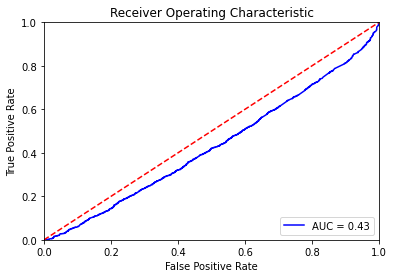

In [ ]:
import sklearn.metrics as metrics

def ft_prediction_wrapper(texts, model):
    labels = []
    for text in texts:
        labeled, confidences = model.predict(text, k=-1)
        label = dict(zip(labeled, confidences))
        labels.append(label)
    df = pd.DataFrame(labels)
    return df

# calculate the fpr and tpr for all thresholds of the classification
probs = ft_prediction_wrapper(test_df.reviewText.values.tolist(), model)
preds = probs.values[:,1]
y_test = test_df['new_data1'].values
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
test_df.new_data.value_counts()

__label__old    2989
__label__new    2831
Name: new_data, dtype: int64